In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from models.AlexNet import AlexNet
from models.VGG13 import VGG13
from models.FrankNet import FrankNet

# Setup

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = Compose([
    Resize((227,227)),
    ToTensor(),
    Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
])

training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

batch_size = 8

train_loader = DataLoader(training_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def train(dataloader, model, loss_fn, optimizer):
    # Obtém o tamanho do dataset
    size = len(dataloader.dataset)
    # Indica que o modelo está em processo de treinamento
    model.train()

    # Define a loss total do treinamento
    totalLoss = 0

    # Itera sobre os lotes
    for batch, (X, y) in enumerate(dataloader):
        # transforma as entradas no formato do dispositivo utilizado (CPU ou GPU)
        X, y = X.to(device), y.to(device)

        # Faz a predição para os valores atuais dos parâmetros
        pred = model(X)

        # Estima o valor da função de perda
        loss = loss_fn(pred, y)

        # Incrementa a loss total
        totalLoss += loss

        # Backpropagation

        # Limpa os gradientes
        optimizer.zero_grad()

        # Estima os gradientes
        loss.backward()

        # Atualiza os pesos da rede
        optimizer.step()

        if batch % 128 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

    print(f"Epoch average loss: {totalLoss/len(dataloader):>7f}")

def test(dataloader, model, loss_fn):
    # Obtém o tamanho do dataset
    size = len(dataloader.dataset)

    # Obtém o número de lotes (iterações)
    num_batches = len(dataloader)

    # Indica que o modelo está em processo de teste
    model.eval()

    # Inicializa a perda de teste e a quantidade de acertos com 0
    test_loss, correct = 0, 0

    # Desabilita o cálculo do gradiente
    with torch.no_grad():
        # Itera sobre o conjunto de teste
        for X, y in dataloader:
            # transforma as entradas no formato do dispositivo utilizado (CPU ou GPU)
            X, y = X.to(device), y.to(device)
            # Realiza a predição
            pred = model(X)

            # Calcula a perda
            test_loss += loss_fn(pred, y).item()
            # Verifica se a predição foi correta
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Determina a perda média e a proporção de acertos
    test_loss /= num_batches
    correct /= size
    # LOG: mostra a acurácia e a perda
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Models

## VGG13

In [4]:
vgg13 = VGG13().to(device)
print(vgg13)

VGG13(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

### Hyper Parameters

In [5]:
learning_rate = 0.001
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg13.parameters(), lr=learning_rate)

### Train

In [6]:
for t in range(epochs):
    print(f"-------------------------------\nEpoch {t+1}")
    train(train_loader, vgg13, loss_fn, optimizer)
test(test_loader, vgg13, loss_fn)
print("Done!")

-------------------------------
Epoch 1
loss: 2.337640 [    0/50000]
loss: 7.743907 [ 1024/50000]
loss: 5.321716 [ 2048/50000]
loss: 3.057783 [ 3072/50000]
loss: 2.312211 [ 4096/50000]
loss: 2.311805 [ 5120/50000]
loss: 2.299826 [ 6144/50000]
loss: 2.301305 [ 7168/50000]
loss: 2.306936 [ 8192/50000]
loss: 2.289879 [ 9216/50000]
loss: 2.315549 [10240/50000]
loss: 2.303707 [11264/50000]
loss: 2.295030 [12288/50000]
loss: 2.310058 [13312/50000]
loss: 2.309554 [14336/50000]
loss: 2.312754 [15360/50000]
loss: 2.301589 [16384/50000]
loss: 2.294831 [17408/50000]
loss: 2.296361 [18432/50000]
loss: 2.297880 [19456/50000]
loss: 2.307946 [20480/50000]
loss: 2.315095 [21504/50000]
loss: 2.307427 [22528/50000]
loss: 2.305738 [23552/50000]
loss: 2.315507 [24576/50000]
loss: 2.295645 [25600/50000]
loss: 2.322690 [26624/50000]
loss: 2.314177 [27648/50000]
loss: 2.285610 [28672/50000]
loss: 2.290216 [29696/50000]
loss: 2.307653 [30720/50000]
loss: 2.291765 [31744/50000]
loss: 2.318243 [32768/50000]
los

### Test

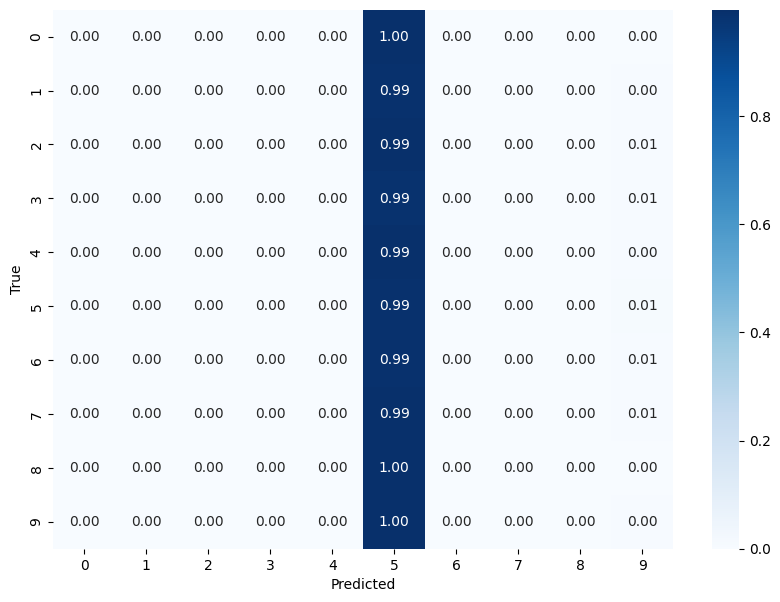

In [7]:
vgg13.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

# Iterate over the test data and generate predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg13(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## AlexNet

In [8]:
alexnet = AlexNet().to(device)
print(alexnet)

AlexNet(
  (conv_layer): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (full_layer): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_feat

### Hyper Parameters

In [9]:
learning_rate = 0.001
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr=learning_rate)

### Train

In [10]:
for t in range(epochs):
    print(f"-------------------------------\nEpoch {t+1}")
    train(train_loader, alexnet, loss_fn, optimizer)
test(test_loader, alexnet, loss_fn)
print("Done!")

-------------------------------
Epoch 1
loss: 2.300751 [    0/50000]
loss: 2.299767 [ 1024/50000]
loss: 2.312573 [ 2048/50000]
loss: 2.310058 [ 3072/50000]
loss: 2.335584 [ 4096/50000]
loss: 2.303738 [ 5120/50000]
loss: 2.297013 [ 6144/50000]
loss: 2.302184 [ 7168/50000]
loss: 2.304862 [ 8192/50000]
loss: 2.294783 [ 9216/50000]
loss: 2.307423 [10240/50000]
loss: 2.301349 [11264/50000]
loss: 2.304394 [12288/50000]
loss: 2.301732 [13312/50000]
loss: 2.303105 [14336/50000]
loss: 2.306554 [15360/50000]
loss: 2.297076 [16384/50000]
loss: 2.291605 [17408/50000]
loss: 2.301523 [18432/50000]
loss: 2.299304 [19456/50000]
loss: 2.306435 [20480/50000]
loss: 2.305217 [21504/50000]
loss: 2.295892 [22528/50000]
loss: 2.311646 [23552/50000]
loss: 2.301292 [24576/50000]
loss: 2.306691 [25600/50000]
loss: 2.307656 [26624/50000]
loss: 2.303465 [27648/50000]
loss: 2.301157 [28672/50000]
loss: 2.289495 [29696/50000]
loss: 2.305433 [30720/50000]
loss: 2.296431 [31744/50000]
loss: 2.308960 [32768/50000]
los

KeyboardInterrupt: 

### Test

In [ ]:
alexnet.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

# Iterate over the test data and generate predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = alexnet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## FrankNet

In [ ]:
franknet = FrankNet().to(device)
print(franknet)

### Hyper Parameters

In [ ]:
learning_rate = 0.001
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(franknet.parameters(), lr=learning_rate)

### Train

In [ ]:
for t in range(epochs):
    print(f"-------------------------------\nEpoch {t+1}")
    train(train_loader, franknet, loss_fn, optimizer)
test(test_loader, franknet, loss_fn)
print("Done!")

### Test

In [ ]:
franknet.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

# Iterate over the test data and generate predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = franknet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()